<a href="https://colab.research.google.com/github/md-marop-hossain/Enhancing-Ocular-Disease-Diagnosis-in-Fundus-Images-CSE499B-project/blob/main/retina_blood_vessel_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retina Blood Vessel UNET


In [ ]:
!pip install imantics --quiet

  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imantics
from PIL import Image
from skimage.transform import resize
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
images_dir ='/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/train/image'
masks_dir = '/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/train/mask'

In [ ]:
images_listdir = os.listdir(images_dir)
masks_listdir = os.listdir(masks_dir)
random_images = np.random.choice(images_listdir, size = 9, replace = False)

In [ ]:
print(len(images_listdir))
print(len(masks_listdir))

80
80


In [ ]:
image_size=512
input_image_size=(512,512)

In [ ]:
def read_image(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [ ]:
number=200

# Input images

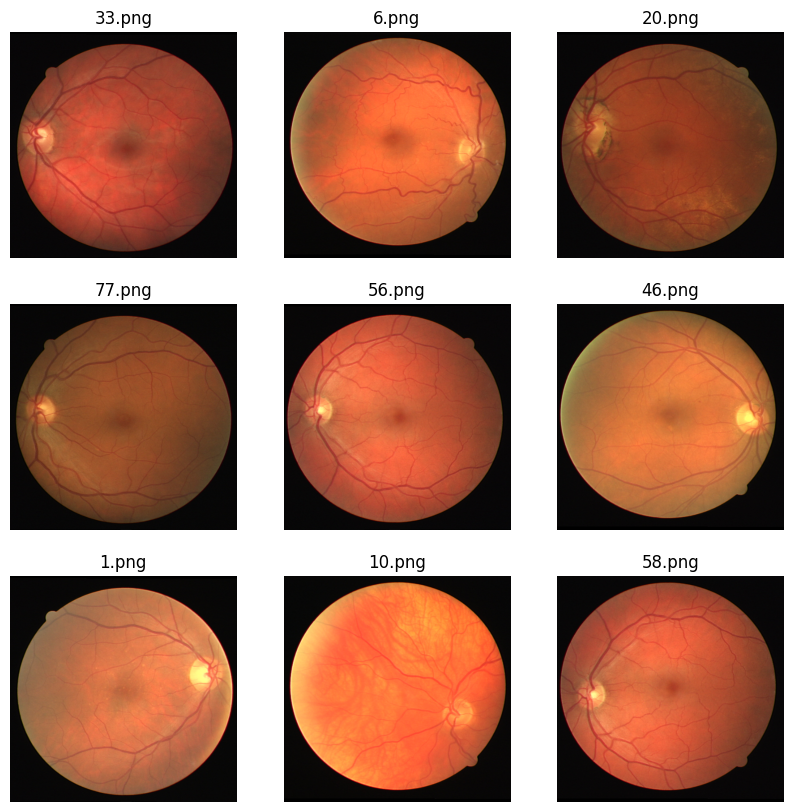

In [ ]:
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        img = read_image(f"{images_dir}/{random_images[i]}")
        ax.set_title(f"{random_images[i]}")
        ax.imshow(img)
        ax.axis('off')

# Ground truth masks

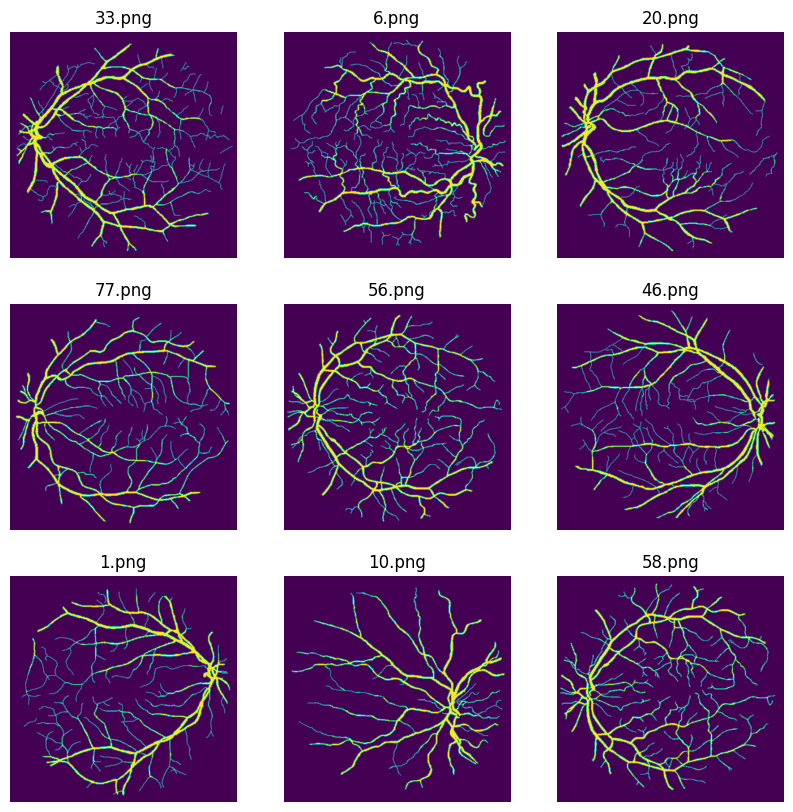

In [ ]:
fig, ax = plt.subplots(rows, cols, figsize = (10,10))
for i, ax in enumerate(ax.flat):
    if i < len(random_images):
        file=random_images[i]
        if os.path.exists(os.path.join(masks_dir,file)):
            img = read_image(f"{masks_dir}/{file}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.set_title(f"{random_images[i]}")
            ax.imshow(img)
            ax.axis('off')
        else:
            print('not exist')

In [ ]:
MASKS=np.zeros((1,image_size, image_size, 1), dtype=bool)
IMAGES=np.zeros((1,image_size, image_size, 3),dtype=np.uint8)

for j,file in enumerate(images_listdir[0:number]):   ##the smaller, the faster
    try:
        image = read_image(f"{images_dir}/{file}")
        image_ex = np.expand_dims(image, axis=0)
        IMAGES = np.vstack([IMAGES, image_ex])
        mask = read_image(f"{masks_dir}/{file}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask.reshape(512,512,1)
        mask_ex = np.expand_dims(mask, axis=0)
        MASKS = np.vstack([MASKS, mask_ex])
    except:
        print(file)
        continue

In [ ]:
images=np.array(IMAGES)[1:number+1]
masks=np.array(MASKS)[1:number+1]
print(images.shape,masks.shape)

(80, 512, 512, 3) (80, 512, 512, 1)


In [ ]:
images_train, images_test, masks_train, masks_test = train_test_split(
    images, masks, test_size=0.4, random_state=42)

In [ ]:
print(len(images_train), len(masks_train))

48 48


# U-Net

In [ ]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding="same")(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    return conv

def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)
    outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation="sigmoid")(decode4)
    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#unet_model.summary()

# Train
Suitable number epoch range is narrow.

In [17]:
unet_result = unet_model.fit(
    images_train, masks_train,
    validation_split = 0.2, batch_size = 4, epochs = 20)

Epoch 1/20
10/10 [==============================] - 1200s 119s/step - loss: -99.0103 - accuracy: 0.3846 - val_loss: 2300.2148 - val_accuracy: 0.8802
Epoch 2/20
10/10 [==============================] - 1185s 119s/step - loss: -237.2427 - accuracy: 0.5956 - val_loss: -94676.0859 - val_accuracy: 5.1689e-04
Epoch 3/20
10/10 [==============================] - 1185s 119s/step - loss: -282.9237 - accuracy: 0.4379 - val_loss: -2606.4500 - val_accuracy: 0.0281
Epoch 4/20
10/10 [==============================] - 1195s 120s/step - loss: -317.8007 - accuracy: 0.3534 - val_loss: 11596.2373 - val_accuracy: 0.8392
Epoch 5/20
10/10 [==============================] - 1204s 121s/step - loss: -347.0135 - accuracy: 0.3151 - val_loss: 2567.6721 - val_accuracy: 0.7108
Epoch 6/20
10/10 [==============================] - 1212s 122s/step - loss: -378.6388 - accuracy: 0.3165 - val_loss: 191.7496 - val_accuracy: 0.6124
Epoch 7/20
10/10 [==============================] - 1198s 120s/step - loss: -410.1755 - accura

# Predict valid images

In [18]:
def show_result(idx, og, unet, target, p):

    fig, axs = plt.subplots(1, 3, figsize=(12,12))
    axs[0].set_title("Original "+str(idx) )
    axs[0].imshow(og)
    axs[0].axis('off')

    axs[1].set_title("U-Net: p>"+str(p))
    axs[1].imshow(unet)
    axs[1].axis('off')

    axs[2].set_title("Ground Truth")
    axs[2].imshow(target)
    axs[2].axis('off')

    plt.show()

In [19]:
!export TF_FORCE_GPU_ALLOW_GROWTH=True
import tensorflow as tf

In [20]:
with tf.device('/cpu:0'):
    unet_predict = unet_model.predict(images_test)

1/1 [==============================] - 261s 261s/step


In [ ]:
len(images_test)

In [ ]:
r1,r2,r3,r4=0.7,0.8,0.9,0.99

In [ ]:
unet_predict1 = (unet_predict > r1).astype(np.uint8)
unet_predict2 = (unet_predict > r2).astype(np.uint8)
unet_predict3 = (unet_predict > r3).astype(np.uint8)
unet_predict4 = (unet_predict > r4).astype(np.uint8)

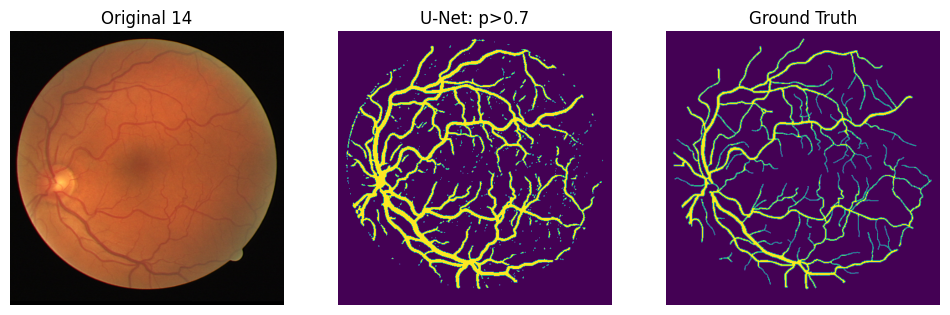

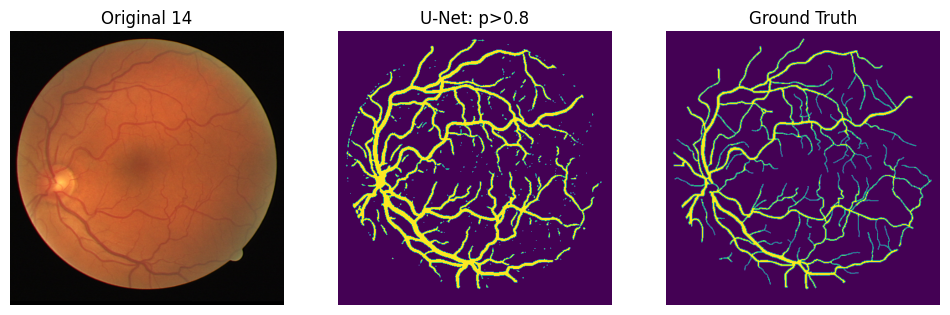

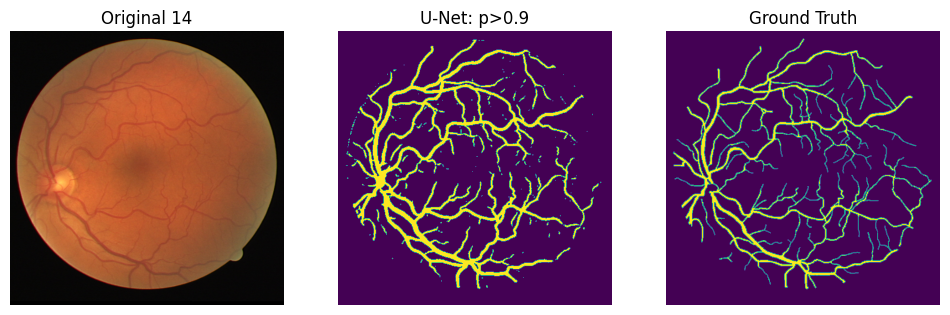

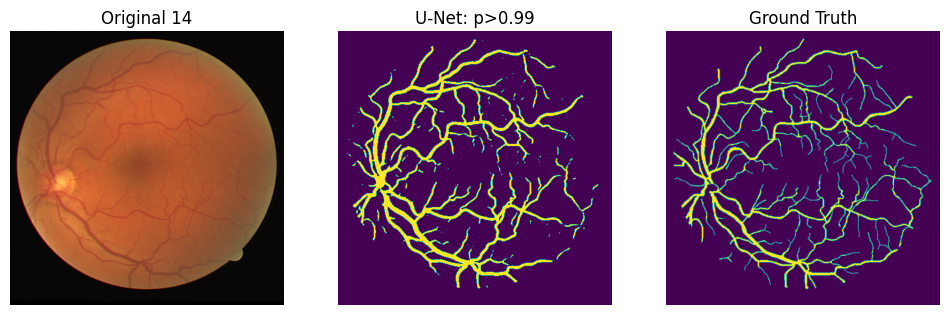

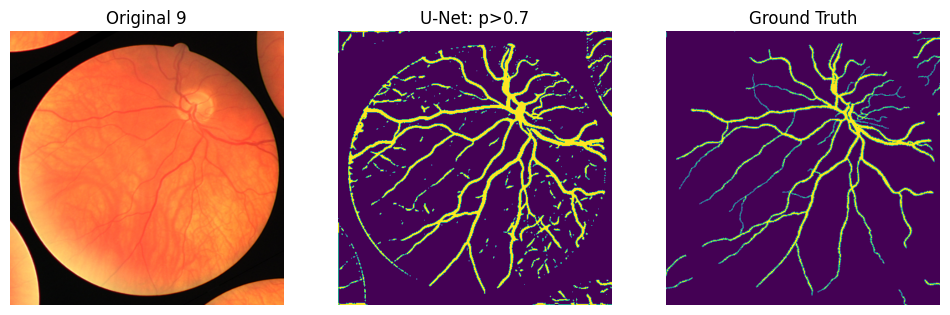

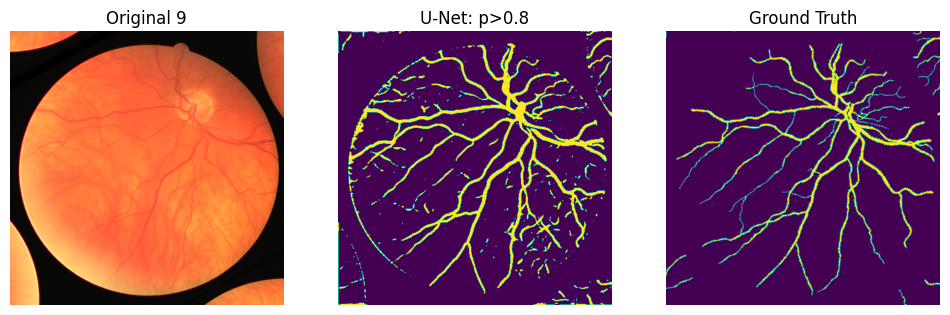

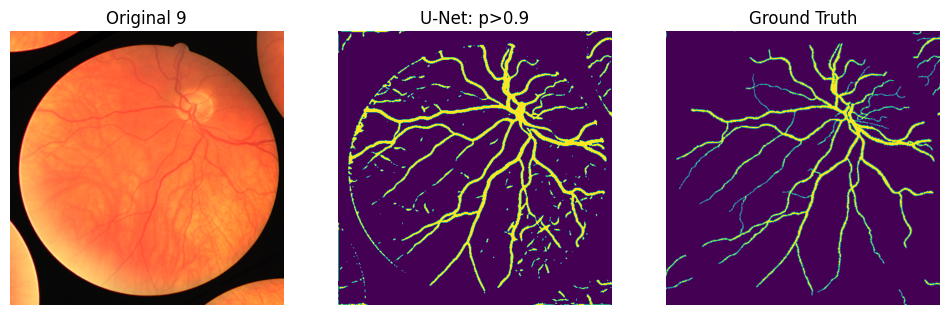

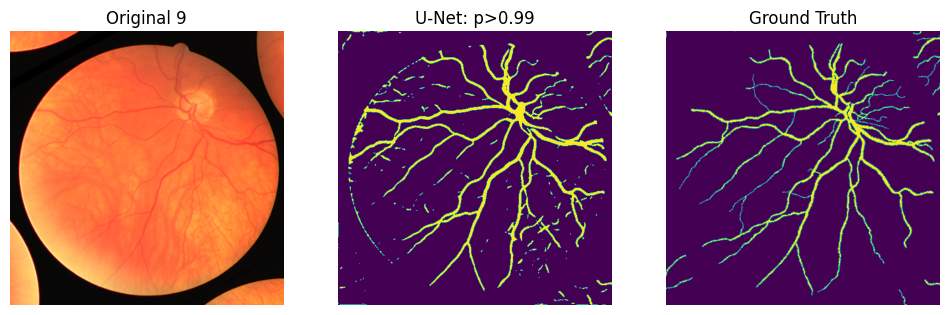

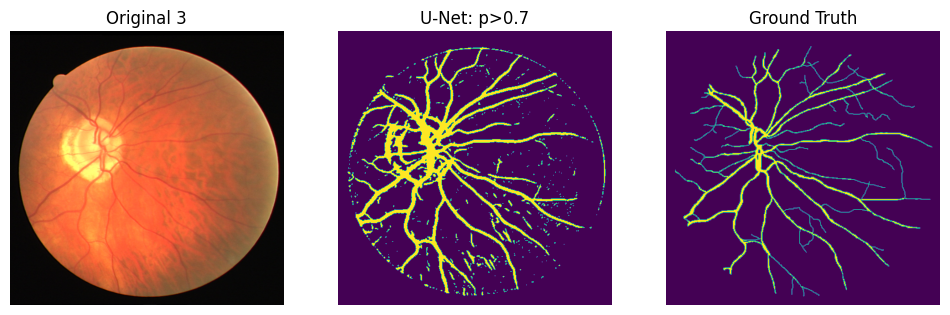

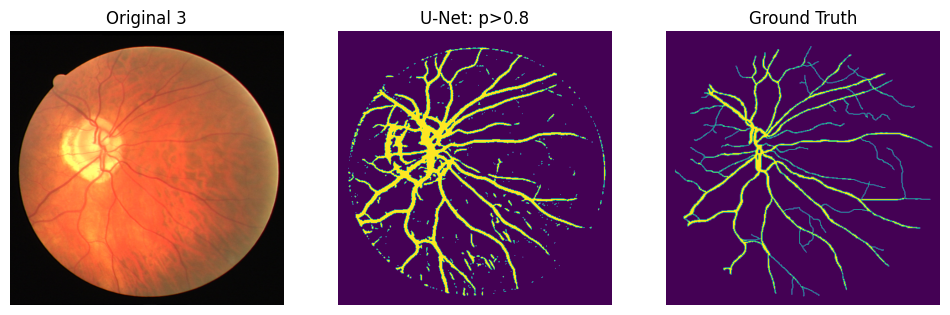

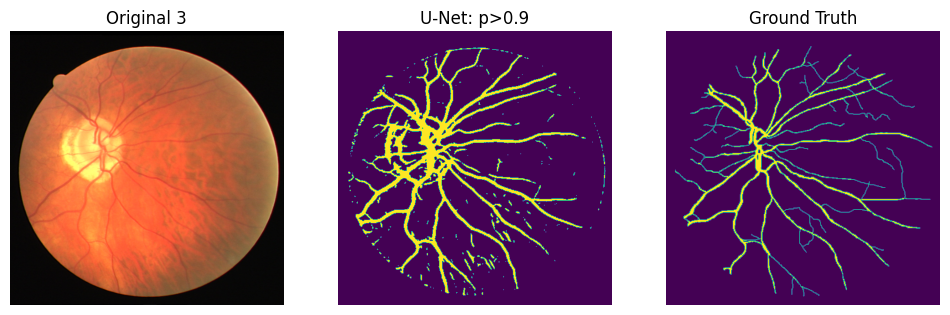

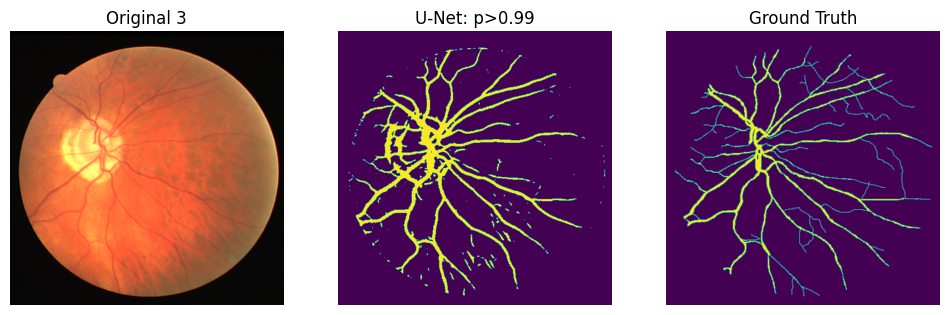

In [24]:
show_test_idx = random.sample(range(len(unet_predict)), 3)
for idx in show_test_idx:
    show_result(idx, images_test[idx], unet_predict1[idx], masks_test[idx], r1)
    show_result(idx, images_test[idx], unet_predict2[idx], masks_test[idx], r2)
    show_result(idx, images_test[idx], unet_predict3[idx], masks_test[idx], r3)
    show_result(idx, images_test[idx], unet_predict4[idx], masks_test[idx], r4)
    print()

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [26]:
from keras.utils import normalize
import os
import cv2 as cv
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [27]:
image_directory_train="/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/train/image"
mask_directory_train="/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/train/mask"
image_directory_test="/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/test/image"
mask_directory_test="/content/drive/MyDrive/Colab Notebooks/Files external /retinabloodvessel/Data/test/mask"

In [28]:
SIZE = 256
train_image_dataset = []
train_mask_dataset = []
test_image_dataset = []
test_mask_dataset = []

In [29]:
train_images = os.listdir(image_directory_train)

In [30]:
for i, image_name in enumerate(train_images):
    if (image_name.split('.')[1] == 'png'):
#         print(image_directory_train+"/"+image_name)
        image = cv.imread(image_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_image_dataset.append(np.array(image))

In [31]:
train_masks = os.listdir(mask_directory_train)
for i, image_name in enumerate(train_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_train+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_dataset.append(np.array(image))

In [32]:
#Normalize images
train_image_dataset = np.expand_dims(normalize(np.array(train_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
train_mask_dataset = np.expand_dims((np.array(train_mask_dataset)),3) /255.

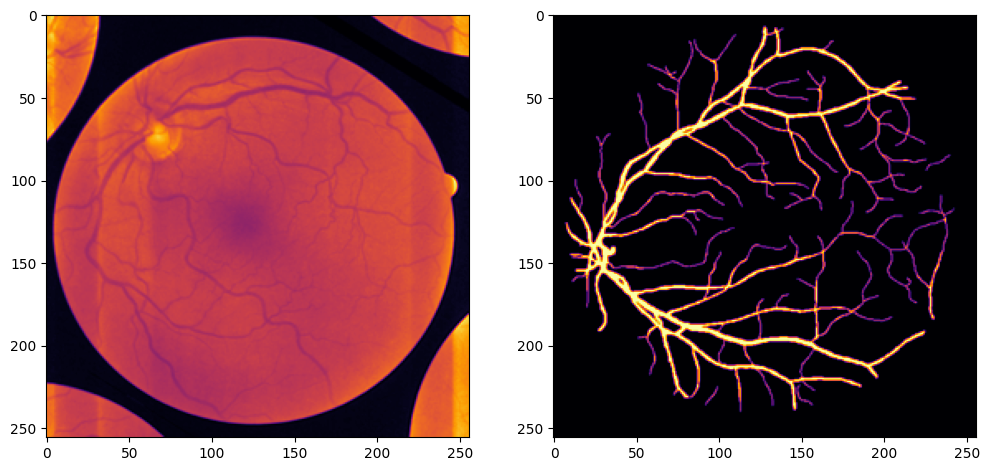

In [33]:
import random
import numpy as np
image_number = random.randint(0, len(train_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(train_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(train_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [34]:
test_images = os.listdir(image_directory_test)
test_masks = os.listdir(mask_directory_test)

In [35]:
for i, image_name in enumerate(test_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(image_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_image_dataset.append(np.array(image))

In [ ]:
for i, image_name in enumerate(test_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv.imread(mask_directory_test+"/"+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        test_mask_dataset.append(np.array(image))

In [ ]:
#Normalize images
test_image_dataset = np.expand_dims(normalize(np.array(test_image_dataset), axis=1),3)
#D not normalize masks, just rescale to 0 to 1.
test_mask_dataset = np.expand_dims((np.array(test_mask_dataset)),3) /255.

In [ ]:
image_number = random.randint(0, len(test_image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(test_image_dataset[image_number], (256, 256)),cmap="inferno")
plt.subplot(122)
plt.imshow(np.reshape(test_mask_dataset[image_number], (256, 256)),cmap="inferno")
plt.show()

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D,  concatenate, Conv2DTranspose, BatchNormalization, Dropout

In [ ]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [41]:
IMG_HEIGHT = train_image_dataset.shape[1]
IMG_WIDTH  = train_image_dataset.shape[2]
IMG_CHANNELS = train_image_dataset.shape[3]

In [42]:
model= simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
history = model.fit(train_image_dataset, train_mask_dataset,
                    batch_size = 32,
                    verbose=1,
                    epochs=80,
                    validation_data=(test_image_dataset, test_mask_dataset),
                    shuffle=False)

Epoch 1/80
3/3 [==============================] - 66s 19s/step - loss: 0.6750 - accuracy: 0.7274 - val_loss: 0.6455 - val_accuracy: 0.8117
Epoch 2/80
3/3 [==============================] - 62s 19s/step - loss: 0.5934 - accuracy: 0.8135 - val_loss: 0.3823 - val_accuracy: 0.8117
Epoch 3/80
3/3 [==============================] - 63s 19s/step - loss: 0.4650 - accuracy: 0.8135 - val_loss: 0.5170 - val_accuracy: 0.8117
Epoch 4/80
3/3 [==============================] - 59s 18s/step - loss: 0.4299 - accuracy: 0.8136 - val_loss: 0.3847 - val_accuracy: 0.8117
Epoch 5/80
3/3 [==============================] - 61s 19s/step - loss: 0.3802 - accuracy: 0.8136 - val_loss: 0.3967 - val_accuracy: 0.8117
Epoch 6/80
3/3 [==============================] - 60s 19s/step - loss: 0.3496 - accuracy: 0.8136 - val_loss: 0.3688 - val_accuracy: 0.8117
Epoch 7/80
3/3 [==============================] - 68s 23s/step - loss: 0.3245 - accuracy: 0.8136 - val_loss: 0.3265 - val_accuracy: 0.8117
Epoch 8/80
3/3 [===========

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()